<a href="https://colab.research.google.com/github/treid003/Collection-Growth-Curve-Notebook/blob/main/Collection_Growth_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collection Growth Curve Notebook
Travis Reid ([@TReid803](https://twitter.com/TReid803))
    
Web Science and Digital Libraries Research Group ([@WebSciDL](https://twitter.com/WebSciDL))
    
    
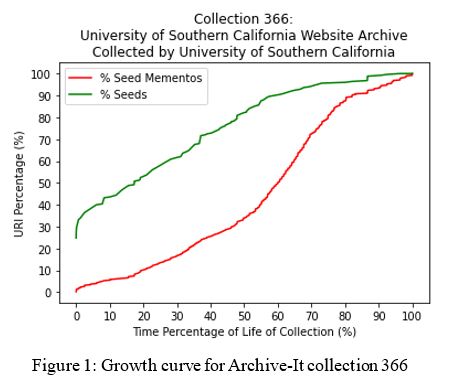

A collection growth curve (Figure 1) can be used to gain a better understanding of the seed curation and crawling behavior of a web archive collection. In a collection growth curve there are two lines, which are the seed line (green) and the seed memento line (red). The seed line can represent part of the curational engagement with a collection since it can show when the archivist first crawled the seeds in a collection. The seed memento line represents the growth of the collection. The x-axis for a collection growth curve represents the percentage of the life of the collection. The y-axis for a collection growth curve represents the percentage of URIs in the collection at a given time.

If a line is at the upper left corner, then most of the seeds or seed mementos have been added to the collection earlier in the collection's life. If a line is at the lower right corner, then most of the seeds or seed mementos have been added to the collection later in the collection's life. If a seed line is a diagonal line, then the archivist added new seeds frequently during the collection's life.

Read section 5.1 of the paper "[The Many Shapes of Archive-It](https://arxiv.org/abs/1806.06878)" to learn more about collection growth curves.

    
## Using This Growth Curve Notebook
1. Update the variables in the *first code cell* with the information needed for the collection and the text derivative file
1. Run the *second code cell*
1. Restart the runtime by selecting **Runtime->Restart and run all**
1. After this is done, the notebook will begin to execute all code cells and will display the growth curve and other information at the bottom of the notebook

## Requirements
The text derivative used by the notebook needs to be similar to the [webpage text derivative](https://docs.google.com/presentation/d/18lNE-eTSK5O2zKExxJjMppeSnGLCogNmGmBYVvZM0yo/edit#slide=id.g88cc84ee8e_0_216) from [Archives Unleashed Cloud](http://cloud.archivesunleashed.org/). 

The fields needed in the derivative in this exact order:
1. Crawl date
1. Domain
1. URL
1. Remaining fields are optional

Also, the text derivative file used by the notebook needs to either have an UTF-8 encoding or an encoding that includes a Byte Order Mark (BOM).

In [ ]:
# First code cell
## You can change these variables to use the notebook with a different collection
collectionID = 6337
textDerivativeFileName = "6337-fulltext.csv" #"File_Name"
urlForDownload = "https://sandbox.zenodo.org/record/666588/files/6337-fulltext_Win_utf8NoBOM.zip?download=1"
fileCompressionType = "zip" #"ZIP" or "GZIP"

In [ ]:
# Second code cell that must be ran before restarting the runtime
# Installing packages that requires a restart
!pip3 install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.3.2)


# Downloading And Including Dependencies

In [ ]:
#Install packages
!pip3 install pandas
!pip3 install numpy
!pip install tqdm
!pip install surt
!pip install chardet

# Archive-It Utilities (https://github.com/oduwsdl/archiveit_utilities)
!pip3 install aiu

     |████████████████████████████████| 92kB 2.8MB/s 
  Created wheel for surt: filename=surt-0.3.1-cp36-none-any.whl size=14560 sha256=cdbd974165f53dca61e9a3fe61314ed2cc16bb42cafc129423efc90a8226a572
  Stored in directory: /root/.cache/pip/wheels/70/24/15/06ed122c935df0de79644c18f0404a0e6c4fcf6cbfa04f4d2e
Successfully built surt
     |████████████████████████████████| 40kB 2.0MB/s 
  Created wheel for aiu: filename=aiu-0.1.1a4-cp36-none-any.whl size=25624 sha256=7360ae337f2e918cfd20b0143ab2f855fcb501967359dcec42bfc2f0bfc7ffdb
  Stored in directory: /root/.cache/pip/wheels/e6/8d/63/6cc5110256de1f81966fcb4dedf27fe3a38f208c27dd333368
  Created wheel for requests-futures: filename=requests_futures-1.0.0-cp36-none-any.whl size=7013 sha256=7e9aedb34b81a953c92352b06c4947cd5676c62c0edaa326fc6383818fd6eb42
  Stored in directory: /root/.cache/pip/wheels/26/d0/f5/dc4e4a37bbe55c9acf967d2bd899152412c1e49c227f5395ff
Successfully built aiu requests-futures


In [ ]:
#Import modules
from aiu import ArchiveItCollection as aic
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
from surt import surt
from chardet.universaldetector import UniversalDetector
from tqdm.notebook import tqdm

# Getting Collection Metadata

In [ ]:
# Use Archive-It Utilities to get the metadata for the collection
collectionMetadata = aic(collectionID)

# Progress Bar Functions

In [ ]:
# Functions for creating progress bars
def getProgressBarForRange(maxNum, description):
  progressBar = tqdm(range(maxNum), desc=description)
  return progressBar

def getProgressBarForFile(filePath, description):
  !grep -ac "." "$filePath" > "temp.txt"
  with open("temp.txt", 'r') as tempFile:
    lineCount = tempFile.read()

  !rm "temp.txt"
  
  progressBar = tqdm(desc=description)
  progressBar.reset(total=int(lineCount))

  return progressBar

# Retrieving The Text Derivative

In [ ]:
# Downloading the derivative file.

# Create folder for the text derivative
derivativeFolderPath = "./" + collectionMetadata.get_collection_name() + "/"
!mkdir "$derivativeFolderPath"

# Download and extract the file(s)
if fileCompressionType.lower() == "zip" or fileCompressionType.lower() == ".zip":
  downloadedFileName = collectionMetadata.get_collection_name() + ".zip"
  !curl -L "$urlForDownload" > "$downloadedFileName"
  !unzip "$downloadedFileName" -d "$derivativeFolderPath"
  !rm "$downloadedFileName"
elif fileCompressionType.lower() == "gzip" or fileCompressionType.lower() == ".gzip":
  downloadedFileName = derivativeFolderPath + collectionMetadata.get_collection_name() + ".gz"
  !curl -L "$urlForDownload" > "$downloadedFileName"
  !gunzip -r "$downloadedFileName"
  
  # Check to see if the downloaded file is a directory or a text derivative file
  !ls -l "$derivativeFolderPath" | grep -c "^d" > "temp.txt"
  with open("temp.txt", 'r') as f:
    directoryCount = int(f.read())
  !rm "temp.txt"
  
  ## If the file is a directory, then change the name to textDerivativeFileName
  if directoryCount == 0:
    downloadedFileName = derivativeFolderPath + collectionMetadata.get_collection_name()
    newFileName = derivativeFolderPath + textDerivativeFileName
    !mv "$downloadedFileName" "$newFileName"

else:
  print("Error: The compression type cannot be used by this notebook. Use ZIP or GZIP files.")


# Find the text derivative
webpageTextPath = ""
for dirPath, dirNames, fileNames in os.walk(derivativeFolderPath):
  if textDerivativeFileName in fileNames:
    webpageTextPath = os.path.join(dirPath, textDerivativeFileName)
    break # Exit when file is found

if webpageTextPath == "":
  print("Error: The file entered in code cell 2 was not found.")

# Remove the gzip files
!cat "$webpageTextPath" | grep -av ",application/gzip,?" > "temp.txt"
!cat "temp.txt" > "$webpageTextPath"
!rm "temp.txt"

# Convert the file to UTF-8 if necessary
## Read the Byte Order Mark (BOM) if it is included
encodingDetector = UniversalDetector()
with open(webpageTextPath, 'rb') as f:
  line = f.readline()
  encodingDetector.feed(line)
encodingDetector.close()

if encodingDetector.result['confidence'] == 1.0:
  # BOM is included and the encoding should be known
  encodingType = encodingDetector.result['encoding']

  # Convert the file to UTF-8 with no BOM
  !iconv -f "$encodingType" -t utf-8 "$webpageTextPath" > "temp.csv"
  !rm "$webpageTextPath"
  !mv "temp.csv" "$webpageTextPath"
else:
  # If no BOM is found, then it is assumed that the file's encoding is UTF-8
  print("Warning: If the file's encoding is not UTF-8, then an error may occur.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  754k  100  754k    0     0   529k      0  0:00:01  0:00:01 --:--:--  529k
Archive:  Tamiment-Wagner: Civil Rights and Civil Liberties.zip
  inflating: ./Tamiment-Wagner: Civil Rights and Civil Liberties/6337-fulltext.csv  


# Creating Reduced Text Derivative Files
The webpage text derivative will be reduced to only include the lines associated with seed mementos. 

Each line will also be reduced to two fields which will be the *crawl date* and the *URL (URI-R)*.

In [ ]:
# Functions needed to create the necessary files.
def removeTrailingSlash(urlStr):
  urlStr = urlStr.strip()
  if urlStr[-1] == '/':
    urlStr = urlStr[:-1]
  
  return urlStr

## Printing the seed memento file
def printSeedMementosFile(webpageTextPath, seedMementoFilePath):
  # Create a list of surts for the seeds, so that the URLs can be compared later
  seedSurtList = []
  for seedUrl in collectionMetadata.list_seed_uris():
    seedUrl = removeTrailingSlash(seedUrl)
    currentSurt = surt(seedUrl)
    seedSurtList.append(currentSurt)

  # Create progress bar
  progressBar = getProgressBarForFile(webpageTextPath, "Printing Seed Memento File")

  # Compare each URI-R from the webpage text derivative with the seed URI-R
  ## If the URI-Rs are the same then print the needed fields to the seed memento file
  allMementosFile = open(webpageTextPath, 'r')
  seedMementoFile = open(seedMementoFilePath, 'wt')
  for line in allMementosFile:
    progressBar.update()
    for seedSurt in seedSurtList:
      # Get the needed fields from the line which are the crawldate and URI-R
      fieldsList = line.split(',', 3)[:3]
      fieldsList.pop(1)

      currentUrlStr = fieldsList[1]
      currentUrlStr = removeTrailingSlash(currentUrlStr)
      # Compare the URI-Rs of the seed and the current line
      if seedSurt == surt(currentUrlStr):
        reducedLine = ','.join(fieldsList)
        print(reducedLine, file=seedMementoFile)
        break # Move to the next line
    
    

  seedMementoFile.close()
  allMementosFile.close()

  # Remove the domain field from seed_mementos.csv
  !sort -k1,1 -o "$seedMementoFilePath" "$seedMementoFilePath"
  refreshed = progressBar.refresh() # Need to refresh, since some collections get processed too quickly


## Prints the first line from a file (with only seed mementos) to 
## the first crawl date file.
def printFirstCrawlDateFile(seedMementoFilePath, firstCrawlDateFilePath):
  !head -n 1 "$seedMementoFilePath" > "$firstCrawlDateFilePath"

## Prints the last line from a file (with only seed mementos) to 
## the last crawl date file.
def printLastCrawlDateFile(seedMementoFilePath, lastCrawlDateFilePath):
  !tail -n 1 "$seedMementoFilePath" > "$lastCrawlDateFilePath"

In [ ]:
# Print the necessary files

## Print a seed memento file that includes the crawl date and URI-Rs associated 
## with each seed memento.
seedMementoFilePath = "seed_mementos.csv"
printSeedMementosFile(webpageTextPath, seedMementoFilePath)

## Print the first and last crawl date to a file
firstCrawlDateFilePath = "first_crawl_date.csv"
lastCrawlDateFilePath = "last_crawl_date.csv"
printFirstCrawlDateFile(seedMementoFilePath, firstCrawlDateFilePath)
printLastCrawlDateFile(seedMementoFilePath, lastCrawlDateFilePath)

# Creating A Growth Curve Visualization And Printing Other Information

In [ ]:
# Functions for creating the growth curve graph and printing missing seeds
def getCrawlDate(crawlDateStr):
  year = int(crawlDateStr[:4])
  month = int(crawlDateStr[4:6])
  day = int(crawlDateStr[6:8])
  crawlDate = date(year, month, day)
  return crawlDate

def getFirstCrawlDateFromFile(inputFilePath):
  with open(inputFilePath, 'r') as inputFile:
    crawlDateStr = inputFile.readline().split(',')[0]
  
  crawlDate = getCrawlDate(crawlDateStr)
  return crawlDate

def computeX(crawlDate, firstCrawlDate, maxTimeDelta):
  currentTimeDelta = crawlDate - firstCrawlDate
  x = (float(currentTimeDelta.days) / float(maxTimeDelta.days)) * 100
  return x

def computeCoordinatesSeedLine(collectionMetadata, seedMementoFilePath, xList, yList, 
                               excludedSeedsList, firstCrawlDate, maxTimeDelta):
  #Clear the lists
  xList.clear()
  yList.clear()
  excludedSeedsList.clear()

  prevCrawlDate = date(1,1,1)
  prevIndex = -1


  # Create progress bar
  progressBar = getProgressBarForRange(len(collectionMetadata.list_seed_uris()), "Seed line")

  # For each seed go through the file until a match is found.
  # When a match is found, compute the x value and then update the y value.
  ## Need to have x and y lists aligned
  for seedUrl in collectionMetadata.list_seed_uris():
    seedUrl = removeTrailingSlash(seedUrl)
    seedSurt = surt(seedUrl)
    notFound = True

    seedMementoFile = open(seedMementoFilePath, 'r')
    for line in seedMementoFile:
      currentURL = line.split(',')[1]
      currentURL = removeTrailingSlash(currentURL)
      currentUrlSurt = surt(currentURL)
      if currentUrlSurt == seedSurt:
        notFound = False
        crawlDate = getCrawlDate(line.split(',')[0])

        # Determine the current index
        if crawlDate == prevCrawlDate:
          # When the crawl dates are the same, the index used for x and y lists is the same
          currentIndex = prevIndex
        else:
          # when the crawl dates are different, find the index for the current x value
          x = computeX(crawlDate, firstCrawlDate, maxTimeDelta)
          
          try:
            currentIndex = xList.index(x)
          except ValueError:
            # when x cannot be found, then add a new x and y to the lists
            xList.append(x)
            yList.append(0)
            currentIndex = len(xList) - 1

        # A y value is incremented during the first occurance of each seed
        yList[currentIndex] += 1

        prevIndex = currentIndex
        prevCrawlDate = crawlDate
        break # Move to the next seed URL

    seedMementoFile.close()
    progressBar.update()
    if notFound:
      excludedSeedsList.append(seedUrl)
    
  # Sort the xList while ensuring the yList is still aligned
  xTuple, yTuple = zip(*sorted(zip(xList, yList)))
  for i in range(0, len(xList)):
    xList[i] = xTuple[i]
    yList[i] = yTuple[i]

  # Finish computing the y values
  ## y_current = (y_current + y_prev) / numSeedURLs * 100
  for i in range(1, len(yList)):
    yList[i] = yList[i] + yList[i-1]
  # The last element contains the total number of seed URI-Rs that were found
  numSeedURLs = yList[-1]
  for i in range(0, len(yList)):
    yList[i] = (float(yList[i]) / float(numSeedURLs)) * 100

  # Add another x and y value if the last x value is not 100%
  if int(xList[-1]) != 100:
    xList.append(100)
    yList.append(100)

  refreshed = progressBar.refresh()


def computeCoordinatesSeedMementoLine(seedMementoFilePath, xList, yList, 
                                      firstCrawlDate, maxTimeDelta):
  # Clear the lists
  xList.clear()
  yList.clear()

  prevCrawlDate = date(1,1,1)
  prevIndex = -1

  # Create a progress bar
  progressBar = getProgressBarForFile(seedMementoFilePath, "Seed memento line")

  # Go through each line in the input file and then update the y values associated
  # with the crawl date.
  seedMementoFile = open(seedMementoFilePath, 'r')
  for line in seedMementoFile:
    crawlDate = getCrawlDate(line.split(',')[0])

    # Determine the current index
    if crawlDate == prevCrawlDate:
      # When the crawl dates are the same, the index used for x and y lists is the same
      currentIndex = prevIndex
    else:
      # When the crawl dates are different, find the index for the current x value
      x = computeX(crawlDate, firstCrawlDate, maxTimeDelta)
      
      try:
        currentIndex = xList.index(x)
      except ValueError:
        # When x cannot be found, then add a new x and y to the lists
        xList.append(x)
        yList.append(0)
        currentIndex = len(xList) - 1

      # A y value is incremented for each line in the seed memento file
      ## The y value associated with the current x value will be updated
      yList[currentIndex] += 1

      prevIndex = currentIndex
      prevCrawlDate = crawlDate
    
    progressBar.update()

  seedMementoFile.close()
    
  # Sort the xList while ensuring the yList is still aligned
  xTuple, yTuple = zip(*sorted(zip(xList, yList)))
  for i in range(0, len(xList)):
    xList[i] = xTuple[i]
    yList[i] = yTuple[i]

  # Finish computing the y values
  ## y_current = (y_current + y_prev) / numSeedURIs * 100
  for i in range(1, len(yList)):
    yList[i] = yList[i] + yList[i-1]
  # The last element contains the total number of seed URI-Ms that were found
  numSeedURIs = yList[-1]
  for i in range(0, len(yList)):
    yList[i] = (float(yList[i]) / float(numSeedURIs)) * 100

  refreshed = progressBar.refresh()


# The function for printing the growth curve for a collection
def printGrowthCurve(collectionID, collectionMetadata,
                     xListSeedMementoLine, yListSeedMementoLine, 
                     xListSeedLine, yListSeedLine):
  figureSize = [7, 6]
  p1 = plt.rcParams['figure.figsize'] = figureSize
  plt.plot(xListSeedMementoLine, yListSeedMementoLine, "r-")
  plt.plot(xListSeedLine, yListSeedLine, "g-")

  plt.yticks(np.arange(0, 110, 10)) 
  plt.xticks(np.arange(0, 110, 10))

  titleStr = "Collection " + str(collectionID) + ":\n" + collectionMetadata.get_collection_name() + "\n" + "Collected by " + collectionMetadata.get_collectedby()
  plt.title(titleStr)
  plt.ylabel("URI Percentage (%)")
  plt.xlabel("Time Percentage of Life of Collection (%)")
  plt.legend(['% Seed Mementos', '% Seeds']) 

  plt.show()

#Print missing seeds
def printMissingSeeds(collectionMetadata, excludedSeedsList):
  print("\nTotal seeds = " + str(len(collectionMetadata.list_seed_uris())))
  print("Seeds missing from text derivative = " + str(len(excludedSeedsList)))
  
  if len(excludedSeedsList) != 0:
    print("\n" + "Missing seeds:")
    for seedURL in excludedSeedsList:
      print(seedURL)

## Computing Coordinates

In [ ]:
# Compute the coordinates for the points in the seed line and seed memento line

## Compute the maximum time between the first and last crawl date
firstCrawlDate = getFirstCrawlDateFromFile(firstCrawlDateFilePath)
lastCrawlDate = getFirstCrawlDateFromFile(lastCrawlDateFilePath)
maxTimeDelta = lastCrawlDate - firstCrawlDate
excludedSeedsList = []

## Compute coordinates for the points in the seed line
xListSeedLine = []
yListSeedLine = []
computeCoordinatesSeedLine(collectionMetadata, seedMementoFilePath, 
                           xListSeedLine, yListSeedLine, excludedSeedsList,
                           firstCrawlDate, maxTimeDelta)

## Compute coordinates for the points in the seed memento line
xListSeedMementoLine = []
yListSeedMementoLine = []
computeCoordinatesSeedMementoLine(seedMementoFilePath, xListSeedMementoLine, 
                                  yListSeedMementoLine, firstCrawlDate, 
                                  maxTimeDelta)



## Displaying Collection Growth Curve And Printing The Missing Seeds

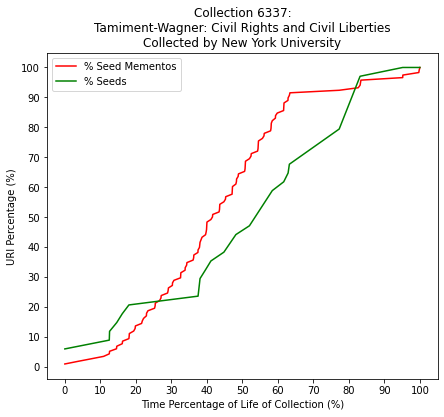


Total seeds = 35
Seeds missing from text derivative = 1

Missing seeds:
http://millionhoodies.nationbuilder.com


In [ ]:
#Print the growth curve and missing seeds
## Print growth curve
printGrowthCurve(collectionID, collectionMetadata,
                 xListSeedMementoLine, yListSeedMementoLine, 
                 xListSeedLine, yListSeedLine)

## Print missing seeds
printMissingSeeds(collectionMetadata, excludedSeedsList)

## Printing Other Information About Collection

In [ ]:
# Print other information that could be useful
print("More Information About The Collection:")
print("  First crawl date: " + str(firstCrawlDate))
print("  Last crawl date: " + str(lastCrawlDate))
print("  Life of the collection: " + str(maxTimeDelta))

More Information About The Collection:
  First crawl date: 2010-12-01
  Last crawl date: 2017-10-21
  Life of the collection: 2516 days, 0:00:00
